# Read FT2 FITS file for Fermi LAT and plot Rock Angle
## Also plot predicted beta angle from Fermi orbit propagated from TLE record

### Robert Cameron
### February 2019

In [1]:
import numpy as np
import calendar as cal
import datetime as dt
import time
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
%matplotlib inline

# for beta angle calculations from Two Line Ephemeris (TLE)
import sys
import urllib
import re
from os.path import expanduser
HOME = expanduser("~")
sys.path.append(HOME+'/Documents/GLAST/sgp4-1.4')
from sgp4.earth_gravity import wgs84
from sgp4.io import twoline2rv
from sgp4.ext import jday, invjday, days2mdhms

In [2]:
# define the Fermi MET zero point in Unix seconds

met0 = dt.date(2001,1,1)  # Fermi MET starts at the beginning of 2001 = Unix seconds 978307200 (without leap seconds)
mett0 = met0.timetuple()
s0 = cal.timegm(mett0)
mets0 = cal.timegm(mett0)
mets0

978307200

In [3]:
#ft2file = "/Users/rac/Desktop/FERMI_POINTING_FINAL_556_2019024_2019031_00.fits"  # use rows 7000:7500
#ft2file = "/Users/rac/Desktop/FERMI_POINTING_FINAL_557_2019031_2019038_00.fits"  # use rows 0:500  # no use for DOE QR
#ft2file = "/Users/rac/Desktop/FERMI_POINTING_FINAL_552_2018361_2019003_00.fits"  # use rows 0:500  # no use for DOE QR
#ft2file = "/Users/rac/Desktop/FERMI_POINTING_PRELIM_559_2019045_2019052_00.fits"  # use rows 7000:7500 # no use for QR
ft2file = "/Users/rac/Desktop/FERMI_POINTING_FINAL_559_2019045_2019052_00.fits"  # use rows 7000:7500 # no use for QR
#fits.info(ft2file)
tbl0 = Table.read(ft2file)
tbl0.columns

<TableColumns names=('START','STOP','SC_POSITION','LAT_GEO','LON_GEO','RAD_GEO','RA_ZENITH','DEC_ZENITH','B_MCILWAIN','L_MCILWAIN','GEOMAG_LAT','IN_SAA','RA_SCZ','DEC_SCZ','RA_SCX','DEC_SCX','RA_NPOLE','DEC_NPOLE','ROCK_ANGLE','LAT_MODE','LAT_CONFIG','DATA_QUAL','LIVETIME','QSJ_1','QSJ_2','QSJ_3','QSJ_4','RA_SUN','DEC_SUN')>

In [4]:
# show the FITS header keywords, but WITHOUT the table column names!

#tbl0.meta # lists top header keywords and values
#tbl0.info   # lists the binary table field names and types, and the number of rows in the table
#tbl0 # this gives more detail than tbl.meta or tbl.info

In [5]:
# limit plot time range

tbl = tbl0[650:1030]
tbl = tbl0[6900:7700]
#tbl = tbl0[0:530]
#tbl = tbl0

In [6]:
# show the FITS file TSTART keyword in a suitable format 
# NOTE: neglects leap seconds!

tstart = tbl.meta['TSTART']
tstart_fmt = time.gmtime(tstart+mets0)
tstart_fmt  # shows the tuple elements and values
tstart_iso = time.strftime('%Y-%m-%d %H:%M:%S UTC', tstart_fmt)
tstart_iso
tstart, tstart_iso

(571795200.0, '2019-02-14 00:00:00 UTC')

In [7]:
#print(tbl['ROCK_ANGLE'].unit)
#print(tbl['START'].unit)
# print(tbl['START','ROCK_ANGLE'])

In [8]:
# calculate Fermi orbit day-night, from Fermi Zenith coordinates and Sun coordinates
ra1 = np.radians(tbl['RA_ZENITH'])
dec1 = np.radians(tbl['DEC_ZENITH'])
ra2 = np.radians(tbl['RA_SUN'])
dec2 = np.radians(tbl['DEC_SUN'])

SunCosAngle = np.sin(dec1)*np.sin(dec2) + np.cos(dec1)*np.cos(dec2)*np.cos(ra1-ra2)
night = [10 if x < -0.385 else 0 for x in SunCosAngle]

#plt.rc('font', size = 15)
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 7))
#plt.plot(SunCosAngle)
#plt.plot(night)

In [9]:
# convert Unix seconds to Datetime structure list

starts = tbl['START']
rock = tbl['ROCK_ANGLE']
startd = pd.to_datetime(starts+mets0,unit='s')
#ss0 = starts[0]+mets0
#time_struc = time.gmtime(starts)    ####### this does not work
startd[0]

Timestamp('2019-02-18 18:59:00')

In [10]:
t = startd[0]
(ty,tmon,td,th,tm,ts) = (t.year,t.month,t.day,t.hour,t.minute,t.second)
ty,tmon,td,th,tm,ts

(2019, 2, 18, 18, 59, 0)

In [11]:
# calculate predicted Fermi beta angle from propagation of Fermi orbit from TLE ephemeris record

webTLE = "http://celestrak.com/NORAD/elements/science.txt"
lines = urllib.request.urlopen(webTLE).readlines()
regex = re.compile(b'(1|2) 33053')
tle = [x.decode().replace('\r\n', '') for x in lines if regex.match(x)]
tle

['1 33053U 08029A   19050.51365474  .00000452  00000-0  90504-5 0  9997',
 '2 33053  25.5822 155.6019 0012380 165.2365 194.8534 15.11183994590043']

In [12]:
satellite = twoline2rv(tle[0], tle[1], wgs84)

In [13]:
betapl = []
for t in startd:
    (ty,tmon,td,th,tm,ts) = (t.year,t.month,t.day,t.hour,t.minute,t.second)
    tj = jday(ty,tmon,td,th,tm,ts)
    pos, vel = satellite.propagate(ty,tmon,td,th,tm,ts)
    pole = np.cross(pos,vel)
    polelen = np.linalg.norm(pole)
# calculate sun coordinates
    n = tj - 2451545.0
    L = (280.460 + 0.9856474 * n) % 360
    g = np.radians((357.528 + 0.9856003 * n) % 360)
    lamda = np.radians(L + 1.915 * np.sin(g) + 0.020 * np.sin(2*g))
    epsilon = np.radians(23.439 - 0.0000004 * n)
    Xsun = np.cos(lamda)
    Ysun = np.cos(epsilon) * np.sin(lamda)
    Zsun = np.sin(epsilon) * np.sin(lamda)
    dotprod = np.dot([Xsun,Ysun,Zsun], pole)
    beta = np.degrees(np.arcsin(dotprod/polelen))
    betapl.append(beta)

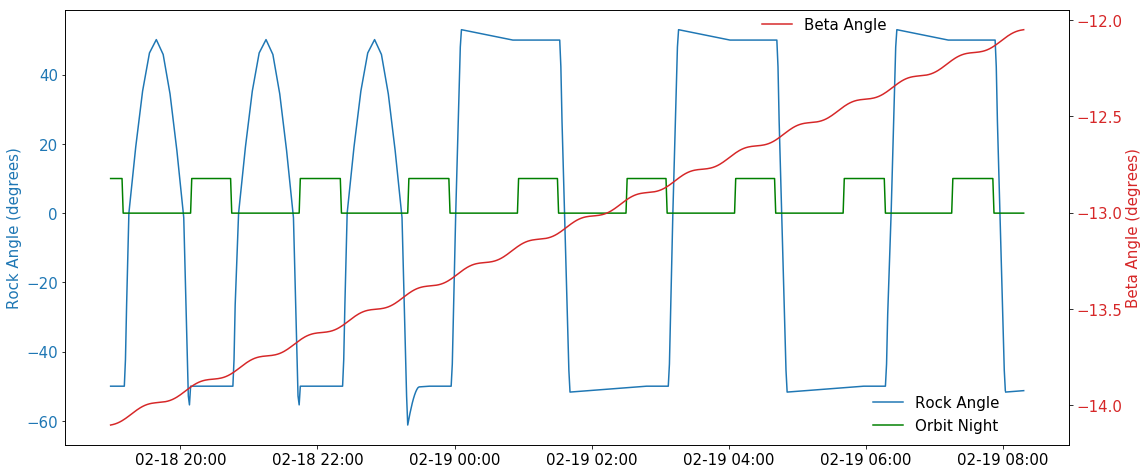

In [25]:
plt.rc('font', size = 15)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(18, 8))

color1 = 'tab:blue'
ax1.set_ylabel('Rock Angle (degrees)', color=color1)
ax1.plot(startd, rock, label='Rock Angle', color=color1)
ax1.plot(startd, night, label='Orbit Night', color='g')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc='center', bbox_to_anchor=(0.867, 0.07), edgecolor='None')
#ax1.ylim([-60,60])

ax2 = ax1.twinx()  # make a second Y-axis, that shares the same x-axis
color2 = 'tab:red'
ax2.set_ylabel('Beta Angle (degrees)', color=color2)  # we already handled the x-label with ax1
ax2.plot(startd, betapl, label = 'Beta Angle', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.legend(loc='center', bbox_to_anchor=(0.756, 0.965),edgecolor='None')
#ax2.ylim([-15,-11])
xTickFmt = mdates.DateFormatter('%m-%d %H:%M')
ax1.xaxis.set_major_formatter(xTickFmt)
#plt.xticks(rotation=40, ha ='right')
#_= plt.xticks(rotation=40, ha ='right')

#fig.tight_layout()  # otherwise the right y-label is slightly clipped